In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

%matplotlib inline

In [2]:
messages_data = pd.read_csv("SMSSpamCollection", sep="\t", names=["label", "message"])

In [3]:
messages_data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
messages_data["message_length"] = messages_data["message"].apply(len)
messages_data.head()

,label,message,message_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [5]:
messages_data["label"].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [6]:
(messages_data["label"].value_counts()/len(messages_data["label"]))*100

ham     86.593683
spam    13.406317
Name: label, dtype: float64

<AxesSubplot:ylabel='label'>

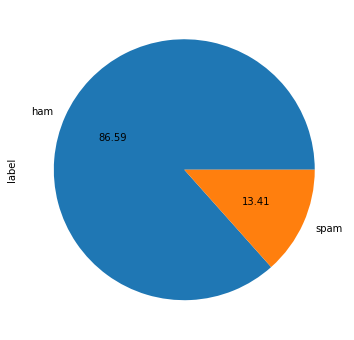

In [7]:
plt.figure(figsize=(12,6))
messages_data["label"].value_counts().plot.pie(autopct="%.2f")

In the above plot we can see that the dataset is imbalanced. The data that is marked "ham" is 86.59% whereas data that is marked "spam" is only 13.40%

So we will take necessary measures to get the required result.

In [8]:
messages_data["message"][0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

This is what the message looks like if its a "ham" or "spam"

In [9]:
print("Shape of the dataset: {}".format(messages_data.shape))

Shape of the dataset: (5572, 3)


array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

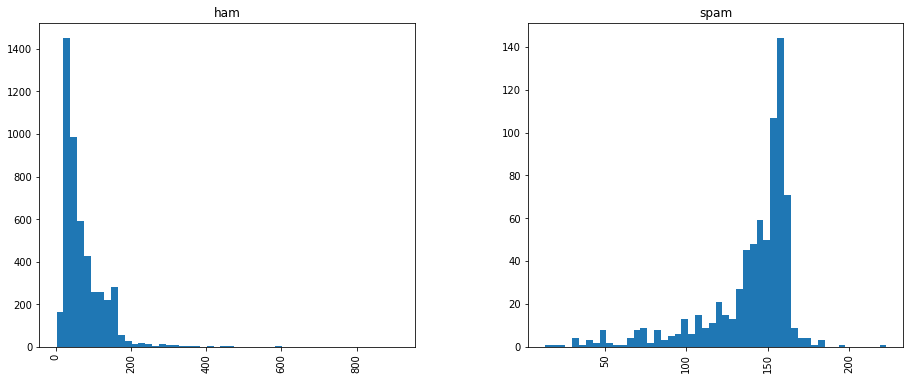

In [10]:
messages_data.hist(column="message_length", by="label", bins=50, figsize=(15,6))

By the above graphs we can discover that spam messages tend to have more character in the message.

In [11]:
messages_data[messages_data.label == "ham"].describe()

,message_length
count,4825.000000
mean,71.482487
std,58.440652
min,2.000000
25%,33.000000
50%,52.000000
75%,93.000000
max,910.000000


In [12]:
messages_data[messages_data.label == "spam"].describe()

,message_length
count,747.000000
mean,138.670683
std,28.873603
min,13.000000
25%,133.000000
50%,149.000000
75%,157.000000
max,223.000000


In [13]:
messages_data[messages_data.message_length == 223].message.iloc[0]

'Hi, this is Mandy Sullivan calling from HOTMIX FM...you are chosen to receive £5000.00 in our Easter Prize draw.....Please telephone 09041940223 to claim before 29/03/05 or your prize will be transferred to someone else....'

How a spam message with most characters look like in first code.

In [14]:
messages_data[messages_data.message_length == 910].message.iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

How a ham message with most charcters look like in second code.

Our dataset contains stopwords and punctuations, we need to clear this in order to proceed further.

### Data cleaning and preprocessing

In [15]:
#porter = PorterStemmer()
word_lemmatizer = WordNetLemmatizer()
corpus = []
for i in range(len(messages_data)):
    review = re.sub("[^a-zA-Z]", " ", messages_data["message"][i])
    review = review.lower()
    review = review.split()
    review = [word_lemmatizer.lemmatize(word) for word in review if not word in stopwords.words("english")]
    review = " ".join(review)
    corpus.append(review)

### Bag of Words model creation

In [16]:
#count_vector = CountVectorizer(max_features=5000)
tfidf_vector = TfidfVectorizer(max_features=2500)
X = tfidf_vector.fit_transform(corpus).toarray()

In [17]:
y = pd.get_dummies(messages_data["label"])
y

,ham,spam
0,1,0
1,1,0
2,0,1
3,1,0
4,1,0
...,...,...
5567,0,1
5568,1,0
5569,1,0
5570,1,0


In [18]:
y = y.iloc[:,1].values

### Train Test Split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67)

### Train model using Naive Bayes classifier

In [20]:
spam_model = MultinomialNB().fit(X_train, y_train)

In [21]:
y_pred = spam_model.predict(X_test)

In [22]:
confusion = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

In [23]:
print("Confusion matrix: ")
print(confusion)

Confusion matrix: 
[[956   2]
 [ 23 134]]


In [24]:
print("Accuracy score: {} which is of no use because the dataset is imbalanced".format(accuracy))

Accuracy score: 0.9775784753363229 which is of no use because the dataset is imbalanced


In [25]:
print("Precision Score: {}".format(precision_score(y_test, y_pred)))
print("Recall Score: {}".format(recall_score(y_test, y_pred)))

Precision Score: 0.9852941176470589
Recall Score: 0.8535031847133758


In [26]:
print("F1 score: {}".format(f1_score(y_test, y_pred)))

F1 score: 0.9146757679180888


### Train model using Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [29]:
y_lr_pred = log_reg.predict(X_test)

In [30]:
print("Confusion Matrix for logistic regression: ")
print(confusion_matrix(y_test, y_lr_pred))
print("Accuracy score: {} is of no use cause data is imbalanced".format(accuracy_score(y_test, y_lr_pred)))

Confusion Matrix for logistic regression: 
[[957   1]
 [ 36 121]]
Accuracy score: 0.9668161434977578 is of no use cause data is imbalanced


In [31]:
print("Precision Score: {}".format(precision_score(y_test, y_lr_pred)))
print("Recall Score: {}".format(recall_score(y_test, y_lr_pred)))

Precision Score: 0.9918032786885246
Recall Score: 0.7707006369426752


In [32]:
print("F1 score: {}".format(f1_score(y_test, y_lr_pred)))

F1 score: 0.8673835125448028


### Train model using Support vector classifier

In [33]:
from sklearn.svm import SVC

In [34]:
svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [35]:
y_svc_pred = svc.predict(X_test)

In [36]:
print("Confusion Matrix for Support Vector Classifier: ")
print(confusion_matrix(y_test, y_svc_pred))
print("Accuracy score: {} is of no use cause data is imbalanced".format(accuracy_score(y_test, y_svc_pred)))

Confusion Matrix for Support Vector Classifier: 
[[957   1]
 [ 20 137]]
Accuracy score: 0.9811659192825112 is of no use cause data is imbalanced


In [37]:
print("Precision Score: {}".format(precision_score(y_test, y_svc_pred)))
print("Recall Score: {}".format(recall_score(y_test, y_svc_pred)))

Precision Score: 0.9927536231884058
Recall Score: 0.8726114649681529


In [38]:
print("F1 score: {}".format(f1_score(y_test, y_svc_pred)))

F1 score: 0.9288135593220339


### Train model using Gradient Boosting Classifier

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

In [40]:
xgb = GradientBoostingClassifier()
xgb.fit(X_train, y_train)

GradientBoostingClassifier()

In [41]:
y_xgb_pred = xgb.predict(X_test)

In [42]:
print("Confusion Matrix for Gradient Boosting Classifier: ")
print(confusion_matrix(y_test, y_xgb_pred))
print("Accuracy score: {} is of no use cause data is imbalanced".format(accuracy_score(y_test, y_xgb_pred)))

Confusion Matrix for Gradient Boosting Classifier: 
[[956   2]
 [ 32 125]]
Accuracy score: 0.9695067264573991 is of no use cause data is imbalanced


In [43]:
print("Precision Score: {}".format(precision_score(y_test, y_xgb_pred)))
print("Recall Score: {}".format(recall_score(y_test, y_xgb_pred)))

Precision Score: 0.984251968503937
Recall Score: 0.7961783439490446


In [44]:
print("F1 score: {}".format(f1_score(y_test, y_xgb_pred)))

F1 score: 0.8802816901408451


### Parameter Tuning and model finalization

In [45]:
from sklearn.model_selection import GridSearchCV

In [46]:
param_grid = {'C':[0.01, 0.1, 1,10, 100], 'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}

In [47]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]})

In [48]:
print(f'Grid search score: {grid_search.score(X_test,y_test)}')
print(f'Best paramters: {grid_search.best_params_}')

Grid search score: 0.9820627802690582
Best paramters: {'C': 100, 'gamma': 0.01}


In [49]:
final_svc_model = grid_search.best_estimator_
y_final_pred = final_svc_model.predict(X_test)

In [50]:
print("Confusion Matrix for Gradient Boosting Classifier: ")
print(confusion_matrix(y_test, y_final_pred))
print("Accuracy score: {} is of no use cause data is imbalanced".format(accuracy_score(y_test, y_final_pred)))

Confusion Matrix for Gradient Boosting Classifier: 
[[955   3]
 [ 17 140]]
Accuracy score: 0.9820627802690582 is of no use cause data is imbalanced


In [51]:
print("Precision Score: {}".format(precision_score(y_test, y_final_pred)))
print("Recall Score: {}".format(recall_score(y_test, y_final_pred)))

Precision Score: 0.9790209790209791
Recall Score: 0.89171974522293


In [52]:
print("F1 score: {}".format(f1_score(y_test, y_final_pred)))

F1 score: 0.9333333333333335
